## Init Project, install requierment and convert the raw dataset

In [ ]:
pip install -r requirements.txt

In [1]:
import pandas as pd
import petl as etl
import pickle

In [ ]:
# Load file label

label1 = etl.fromtext('rumor_detection_acl2017/twitter15/label.txt')
label1 = label1.capture('lines', '(.*):(.*)$', ['label', 'src_tweet_id'])
label1

In [ ]:
# Load file label

label2 = etl.fromtext('rumor_detection_acl2017/twitter16/label.txt')
label2 = label2.capture('lines', '(.*):(.*)$', ['label', 'src_tweet_id'])
label2

In [ ]:
# load file source_tweets

source_tweet1 = etl.fromtext('rumor_detection_acl2017/twitter15/source_tweets.txt')
source_tweet1 = source_tweet1.capture('lines', '(.*)\t(.*)$', ['src_tweet_id', 'content'])
source_tweet1

In [ ]:
# load file source_tweets

source_tweet2 = etl.fromtext('rumor_detection_acl2017/twitter16/source_tweets.txt')
source_tweet2 = source_tweet2.capture('lines', '(.*)\t(.*)$', ['src_tweet_id', 'content'])
source_tweet2

In [ ]:
# join table berdasarkan source tweet id
# rename header sesuai dengan codingan asal

tweet_text1 = etl.join(label1, source_tweet1, key='src_tweet_id')
tweet_text1 = etl.cut(tweet_text1, 'label', 'content')
tweet_text1 = etl.setheader(tweet_text1, ['category', 'text'])
tweet_text1

In [ ]:
tweet_text2 = etl.join(label2, source_tweet2, key='src_tweet_id')
tweet_text2 = etl.cut(tweet_text2, 'label', 'content')
tweet_text2 = etl.setheader(tweet_text2, ['category', 'text'])
tweet_text2

In [ ]:
# untuk mengetahui labelnya apa saja

tweet_text1.distinct('category')

In [ ]:
tweet_text2.distinct('category')

In [ ]:
print(len(tweet_text1))
print(len(tweet_text2))
len(tweet_text1)+len(tweet_text2)

In [ ]:
# menyimpan ke file csv

etl.tocsv(tweet_text1, 'tweet-text-1.csv')
etl.appendcsv(tweet_text2, 'tweet-text-1.csv')

In [ ]:
tweet_text3 = etl.select(tweet_text1, "{category} == 'true' or {category} == 'false'")
tweet_text3 = etl.convert(tweet_text3, 'category', 'replace', 'true', 'ya')
tweet_text3 = etl.convert(tweet_text3, 'category', 'replace', 'false', 'tidak')

tweet_text4 = etl.select(tweet_text2, "{category} == 'true' or {category} == 'false'")
tweet_text4 = etl.convert(tweet_text4, 'category', 'replace', 'true', 'ya')
tweet_text4 = etl.convert(tweet_text4, 'category', 'replace', 'false', 'tidak')

etl.tocsv(tweet_text3, 'tweet-text-binary.csv')
etl.appendcsv(tweet_text4, 'tweet-text-binary.csv')

## Bert Classification

In [2]:
# datapath = 'bbc-text.csv'
datapath = 'tweet-text-binary.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tidak,deep-fried left wings demo-crab cakes barack-a...
1,tidak,42 million dead in bloodiest black friday week...
2,tidak,42 million dead in bloodiest black friday week...
3,ya,#prayforchristopher 5k run .. well we are walk...
4,tidak,a photo of black nurses saving the life of a k...


<AxesSubplot:xlabel='category'>

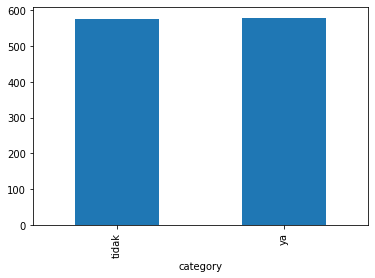

In [3]:
df.groupby(['category']).size().plot.bar()

In [4]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# labels = {'business':0,
#           'entertainment':1,
#           'sport':2,
#           'tech':3,
#           'politics':4
#           }
# labels = {'false':0,
#           'non-rumor':1,
#           'true':2,
#           'unverified':3,
#           }
labels = {'tidak':0,
          'ya':1,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [5]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

923 115 116


In [6]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 4)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
bert_model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

## Save Trained Model

In [ ]:
pickle.dump(model, open('fine-tuned-bert.sav', 'wb'))

## Load Saved Model

In [7]:
bert_model = pickle.load(open('fine-tuned-bert.sav', 'rb'))

In [8]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    result = []
    label_result = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)  
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              result.append(output.cpu().numpy()[0])
#               label_result.append(output.argmax(dim=1).cpu().numpy()[0])
              label_result.append(test_label.cpu().numpy()[0])

              acc = (output.argmax(dim=1) == test_label).sum().item()
              
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return [np.array(result, dtype=np.float32), np.array(label_result, dtype=np.int8)]

In [ ]:
evaluate(bert_model, df_test)

In [9]:
vectorized_data, label_vectorized_data = evaluate(bert_model, df)

Test Accuracy:  0.969


In [10]:
vectorized_data

array([[4.5723724, 0.9174375],
       [5.012532 , 0.       ],
       [5.4816103, 0.       ],
       ...,
       [5.7759914, 0.       ],
       [0.       , 5.796544 ],
       [5.70356  , 0.       ]], dtype=float32)

In [11]:
label_vectorized_data

array([0, 0, 0, ..., 0, 1, 0], dtype=int8)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_data, label_vectorized_data,
                                                    stratify=label_vectorized_data, random_state=1)

## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(random_state=1, hidden_layer_sizes=(4,), max_iter=1000).fit(X_train, y_train)

In [ ]:
clf.predict_proba(X_test)

In [ ]:
clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
len(X_train)

In [ ]:
len(X_test)

In [ ]:
len(vectorized_data)

In [ ]:
865/1154

In [ ]:
289/1154

In [ ]:
clf.n_layers_

## CNN Text Classification

In [19]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# Our dictionary will contain only of the top 7000 words appearing most frequently
# top_words = 7000
top_words = 100

In [ ]:
from keras.datasets import imdb

# Now we split our data-set into training and test data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# Looking at the nature of training data
print(X_train[0])
print(y_train[0])

print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)

print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

In [20]:
# Padding the data samples to a maximum review length in words
max_words = 450

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as
# input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 450, 32)           3200      
                                                                 
 conv1d_1 (Conv1D)           (None, 450, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 225, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_2 (Dense)             (None, 250)               1800250   
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                      

In [22]:
# Fitting the data onto model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2
7/7 - 0s - loss: 0.6975 - accuracy: 0.4960 - val_loss: 0.6925 - val_accuracy: 0.4983 - 346ms/epoch - 49ms/step
Epoch 2/2
7/7 - 0s - loss: 0.6921 - accuracy: 0.5445 - val_loss: 0.6907 - val_accuracy: 0.9689 - 32ms/epoch - 5ms/step
Accuracy: 96.89%
